In [1]:
#Approach:
# Load ground states into a Class.
# Step through all states (levels) loading isospin
# Loop through stable states
#   Get excitations with M1, get M1, isospin, energy
#   Calculate T3 #TODO
# Loop through unstable states
#   Find decays that can produce stable states with excitations we care about, get logfts #TODO
# Step through M1s
#   Calculate isospin rotation coefficient #TODO
#   Calculate BGT0 #TODO
#   Store in structure #TODO
# Plot #TODO
import numpy as np
import utils
import matplotlib.pyplot as plt
import os
import math

m_e = 0.51099895069 #MeV/c
amu_to_MeV = 931.49410242

eps=0.5 #keV, states don't always line up in ensdf files, we use this to determine if two states are close enough to be considered the same



In [2]:
#Code for parsing ground states
def parseJP(JP):
  original_JP = JP
  JP = JP.replace("(", "")
  JP = JP.replace(")", "")
  JP = JP.replace("[", "")
  JP = JP.replace("]", "")
  JP = JP.replace("GE", "")
  JP = JP.replace(":", " ")
  JPParts = JP.split()
  JP = JPParts[0]

  if "+" in JP:
    parity = 1
  elif "-" in JP:
    parity =  -1
  elif "+" in original_JP:
    parity = 1
  elif "-" in original_JP:
    parity = -1
  else:
    print(original_JP)
    parity=1
    
  JP = JP.replace("+", "")
  JP = JP.replace("-", "")

  if "/" in JP:
    num,den = JP.split("/")
    J = float(num)/float(den)
  else:
    J = float(JP)
  return J,parity

#Ground state objects 
class GroundState:
  def __init__(self,*,Z,N,atomType,symbol,J,parity,T,T_status,T3,mass,mass_unc):
    self.Z = Z
    self.N = N
    self.symbol = symbol
    self.atomType = atomType #"STABLE" or "UNSTABLE"
    self.J = J
    self.parity = parity
    self.T = T
    self.T_status = T_status #"ENSDF","Assigned",None
    self.T3 = T3
    self.mass = mass
    self.mass_unc = mass_unc
    self.levels = {}

#Generats an array of valid (stable) ground states indexed by [Z][N]
def parseStableGroundStates(fname):
  ground_states = np.full((200, 200), None, dtype=object)
  with open(fname,"r") as inpFile:
    for iline,line in enumerate(inpFile):
       #strip newline character
      line=line.strip("\n")
      
      #skip header
      if iline>0: 

        #Check line not empty
        if not line=="" and not line==" ":

          #Split into parts
          lineParts = line.split(",")

          Z = None
          N = None
          atomType = None
          symbol = None
          J = None
          parity = None
          T = None
          T_status = None
          T3 = None
          mass = None
          mass_unc = None

          Z = int(lineParts[0])
          N = int(lineParts[1])
          symbol = lineParts[2]
          T = lineParts[27]

          #Only care about for stable nuclei
          if lineParts[12] == "STABLE":
            atomType = "STABLE"
            JP = lineParts[11]
            mass = float(lineParts[46])
            mass_unc = float(lineParts[47])

            #JP is very simple for stable isotopes
            J,parity = parseJP(JP)
          else:
            atomType="USTABLE"
          #Calculate T3
          T3 = (Z - N)/2.

          #Most gnd states do not have isospin defined
          #We use the ENSDF value, and then if it is not assigned
          #We us 
          # 0 if N==Z and an even-even nuclus
          # None if N==Z and an odd-odd or even-odd nucleus
          # |T3| if N!=Z
          # ENSDF value if assigned
          if T=="":
            if N==Z:
              if N%2==0 and Z%2==0:
                T=0
                T_status = "Assigned"
              else:
                T=None
                T_status = None
            else:
              T = abs(T3)
              T_status = "Assigned"
          else:
            T_status = "ENSDF"
            if "/" in T:
              num,den = T.split("/")
              T = float(num)/float(den)
            else:
              T = float(T)

            #Populate with our gnd state objects
            ground_states[Z][N] = GroundState(Z=Z,N=N,symbol=symbol,atomType=atomType,J=J,parity=parity,T=T,T3=T3,T_status=T_status,
                                              mass=mass,mass_unc=mass_unc)
  return ground_states


In [3]:
# 1. Get ground states
# Parses the output of the call: nds.iaea.org/relnsd/v1/data?fields=ground_states&nuclides=all 
# to load properties of the ground states of all nuclei.
# Specifically we populat the GroundState class with
# Z, N, Symbol, 2*spin, parity, 2*isospin, mass, mass_unc
# and then have placeholder lists of the excited states and decays
ground_states = parseStableGroundStates("data/all.csv")

In [4]:
#Code for parsing gammas and levels files - stored in a dict indexed by excited level #
class Level:
  def __init__(self,*,energy,J,parity,bm1,bm1_unc):
    self.energy = energy
    self.J = J
    self.parity = parity
    self.bm1 = bm1
    self.bm1_unc = bm1_unc
    self.T = None
    self.ga_BGT0_squared = None

    #This all gets populated in subsequent fns
    self.bm_decay = None
    self.bp_decay = None
    
def parseGammas(symbol):
  levels = {}

  #Get level energy, twoJ, parity, m1, m1_unc
  with open(f"data/gammas/{symbol}.csv","r") as inpFile:
    for iline,line in enumerate(inpFile):

      #Skip header
      if iline>0:

        #Strip newline char
        line=line.strip("\n")

        #Make sure its not nlack
        if not line=="" and not line==" ":

          #Split into parts
          lineParts = line.split(",")
          endState_str = lineParts[7]
          bm1_str = lineParts[23]

          #Make sure it is a transition to the gnd state and has a BM1 value
          if endState_str=="0" and not bm1_str=="":
            lvl_idx = int(lineParts[3])
            energy = float(lineParts[4])

            bm1 = float(bm1_str)
            if not lineParts[24]=="":
              bm1_unc = float(lineParts[24])
            else:
              bm1_unc = 0

            #JP is very simple for these well-defined levels, not generally true in ENSDF
            JP = lineParts[10]
            J,parity = parseJP(JP)

            levels[lvl_idx] = Level(energy=energy,J=J,parity=parity,bm1=bm1,bm1_unc=bm1_unc)
   
  #Get isospin
  with open(f"data/levels/{symbol}.csv","r") as inpFile:
    for iline,line in enumerate(inpFile):

      #Skip header
      if iline==0:
        continue

      #Strip newline char
      line=line.strip("\n")

      #Make sure line not blank
      if line=="" or line==" ":
        continue

      #split into parts
      lineParts = line.split(",")

      #Skip lines that are too short to have full ingo
      if len(lineParts) < 25:
        continue

      #Get isospin str, make sure not blank
      T_str = lineParts[25]
      if not T_str=="":
        
        if "&" in T_str or "+" in T_str or " " in T_str:
          continue
        
        #If we have valid isospin, get level index
        lvl_idx = int(lineParts[3])

        #Parse isospin
        if "/" in T_str:
          num,den = T_str.split("/")
          T = float(num)/float(den)
        else:
          T = float(T_str)
        
        #Assign isospin to level
        if lvl_idx in levels:
          levels[lvl_idx].T = T
              
  return levels



In [5]:
# 2. Get M1 levels, isospins
#Parses file generated from  nds.iaea.org/relnsd/v1/data?fields=gammas&nuclides=<A><symbol>
#to generate a list of the excited states of a specifiic nucleus. The main point here
#is to get the energy, twoJ, parity, and B(M1) value.
#
#Then parses output of nds.iaea.org/relnsd/v1/data?fields=levels&nuclides=<A><symbol>
#to get the isospin of thes excited states.
for i,j in np.ndindex(ground_states.shape):
  if ground_states[i][j] is not None and ground_states[i][j].atomType=="STABLE":
    A = int(ground_states[i][j].Z + ground_states[i][j].N)
    symbol = str(A)+ground_states[i][j].symbol
    levels = parseGammas(symbol)
    ground_states[i][j].levels = levels

In [6]:
#Code for parsing bm and bp files containing information about beta decays
#Pass in either beta+ or beta- folder, get list of files, step through parsing and extracting relevant info.
#We'll store this either in bms or bps
class Decay:
  def __init__(self,*,Z,N,symbol,J,parity,T,half_life_sec,half_life_sec_unc,logft,logft_unc):
    self.parent_Z = Z
    self.parent_N = N
    self.parent_symbol = symbol
    self.parent_J = J
    self.parent_T = T
    self.parent_parity = parity
    self.half_life_sec = half_life_sec
    self.half_life_sec_unc = half_life_sec_unc
    self.logft = logft
    self.logft_unc = logft_unc

    self.parent_T3 = (Z - N)/2.

#For some reason decay files are not consistent, so we look up which column
def findAndGetValue(headerParts,lineParts,string,outputType="int",defaultValue=None):
  if string in headerParts:
    idx = headerParts.index(string)
    output = lineParts[idx]
    if output=="" or output==" ":
      return defaultValue
    
    if outputType=="int":
      return int(lineParts[idx])
    elif outputType=="float":
      return float(lineParts[idx])
    else:
      return str(lineParts[idx])
  else:
    return defaultValue

def parseDecays(folderName,ground_states):
  fnames = [folderName+i for i in os.listdir(folderName) if i.endswith(".csv")]
  for fname in fnames:
    with open(fname,"r") as inpFile:
      for iline,line in enumerate(inpFile):
        #Skip header
        if iline==0:
          line=line.strip("\n")
          if line=="0":
            break
          headerParts = line.split(",")
          continue

        #Strip newline
        line=line.strip("\n")

        #Skip blank lines
        if line=="" or line==" ":
          continue
      
        #Split by parts
        lineParts = line.split(",")

        logft_str = findAndGetValue(headerParts,lineParts,"log_ft","string")
        hl_str = findAndGetValue(headerParts,lineParts,"half_life_sec","string")
        
        if logft_str is None or hl_str is None:
          continue

        #Parent properties
        p_z = findAndGetValue(headerParts,lineParts,"p_z","int")
        p_n = findAndGetValue(headerParts,lineParts,"p_n","int")
        p_symbol = findAndGetValue(headerParts,lineParts,"p_symbol","string")
        JP = findAndGetValue(headerParts,lineParts,"jp","string")

        #JP parsing
        if JP is None:
          continue
        print(JP)
        p_J,p_parity = parseJP(JP)

        #Get isospin from groundstates
        if ground_states[p_z][p_n] is None:
          continue
        p_T = ground_states[p_z][p_n].T 

        #Daughter properties
        daughter_energy = findAndGetValue(headerParts,lineParts,"daughter_level_energy","string")
        if "+" in daughter_energy or "X" in daughter_energy:
          continue
        daughter_energy = float(daughter_energy)
        d_z = findAndGetValue(headerParts,lineParts,"d_z","int")
        d_n = findAndGetValue(headerParts,lineParts,"d_n","int")
        
        #Decay properties
        half_life_sec = findAndGetValue(headerParts,lineParts,"half_life_sec","float")
        half_life_sec_unc = findAndGetValue(headerParts,lineParts,"unc_hls","float",0)
        log_ft = findAndGetValue(headerParts,lineParts,"log_ft","float")
        log_ft_unc = findAndGetValue(headerParts,lineParts,"unc_lf","float",0)



        #Assign - find the gnd state of the daughter nucleus
        ground_state = ground_states[d_z][d_n]
        if not ground_state is None:

          #Step through levels
          for key in ground_state.levels.keys():
            if abs(daughter_energy - ground_state.levels[key].energy) < eps:
              decay = Decay(Z=p_z,N=p_n,symbol=p_symbol,
                            J=p_J,parity=p_parity,T = p_T,
                            half_life_sec=half_life_sec,half_life_sec_unc=half_life_sec_unc,
                            logft=log_ft,logft_unc=log_ft_unc
                            )
              if "bm" in folderName:
                print("Added bm decay")
                ground_states[d_z][d_n].levels[key].bm_decay = decay
              else:
                print("Added bp decay")
                ground_states[d_z][d_n].levels[key].bp_decay = decay

In [7]:

#3. Step through decays. We will populate the levels objects in the gnd states with
#bm_decay and/or bp_decay Decay objects containing info about the decay to that specific level
parseDecays("data/bms/",ground_states)
parseDecays("data/bps/",ground_states)

1+
1+
7/2+
(5+)
(5+)
(5+)
(5+)
(5+)
(5+)
(5+)
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
0+
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/2-)
(5/

In [8]:
def safeFactorial(val):
  return math.factorial(int(val))

# Algorithmic calculation of CG coefficients, based on 
# https://en.wikipedia.org/wiki/Clebsch%E2%80%93Gordan_coefficients#Relation_to_Wigner_3-j_symbols
def getClebschGordonCoefficient(j1,j2,m1,m2,J,M):
  #Delta fn
  if not M==m1+m2:
    return 0
  
  #term 1
  numerator = (2*J+1)*safeFactorial(j1+j2-J)*safeFactorial(j1-j2+J)*safeFactorial(-j1+j2+J)
  denominator = safeFactorial(j1+j2+J+1)
  if denominator==0:
    return 0
  else:
    term1 = math.sqrt(numerator/denominator)
    
  #term 2
  numerator=safeFactorial(j1-m1)*safeFactorial(j1+m1)*safeFactorial(j2-m2)*safeFactorial(j2+m2)*safeFactorial(J-M)*safeFactorial(J+M)
  term2 = math.sqrt(numerator)

  #term 3
  k_min = max([0,j2-J-m1,j1-J+m2])
  k_max = min([j1+j2-J,j1-m1,j2+m2])
  term3=0
  k = k_min
  while k<=k_max:
    numerator=math.pow(-1,k)

    f1 = safeFactorial(k)
    f2 = safeFactorial(j1+j2-J-k)
    f3 = safeFactorial(j1-m1-k)
    f4 = safeFactorial(j2+m2-k)
    f5 = safeFactorial(J-j2+m1+k)
    f6 = safeFactorial(J-j1-m2+k)
    
    denominator = f1*f2*f3*f4*f5*f6
    if denominator==0:
      return 0
    else:
      term3 += numerator/denominator
    
    k=k+1
    
  CG=term1*term2*term3
  print(f"CG is {CG}")
  return CG


CG is -0.5773502691896257


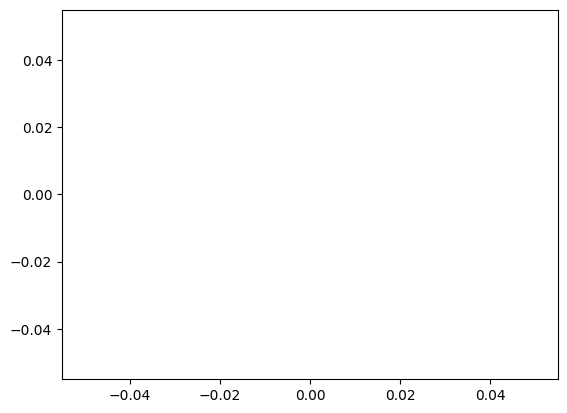

In [9]:
# 4. Step through M1 transitions, calculating rotation coefficent, BGT0. Add to level
for i,j in np.ndindex(ground_states.shape):
  ground_state = ground_states[i][j]
  if ground_state is None or ground_state.atomType=="UNSTABLE":
    continue

  for key in ground_state.levels.keys():
    #Check we have a level and gnd state isospin defined, and a bm1 value
    if ground_state.levels[key].T is None or ground_state.T is None or ground_state.levels[key].bm1 is None:
      continue

    bm_ga_BGT0_squared = None
    bp_ga_BGT0_squared = None

    #Check if we have a bm decay
    if ground_state.levels[key].bm_decay is not None:

      #Check that bm decay has a half life, logft
      if ground_state.levels[key].bm_decay.logft is None or ground_state.levels[key].bm_decay.half_life_sec is None:
        continue

      #Check the bm_parent has a T
      if ground_state.levels[key].bm_decay.parent_T is None:
        continue
      
      #Check the beta decay parent isospin matches the ground state's
      if not ground_state.T == ground_state.levels[key].bm_decay.parent_T:
        continue

      #Calculate CG coefficient in the numerator -  NC term
      j1 = ground_state.T
      m1 = ground_state.T3
      j2 = 1
      m2 = 0
      J = ground_state.levels[key].T
      M = m1 #Should be same as initial

      numerator = getClebschGordonCoefficient(j1,j2,m1,m2,J,M)

      #Calculate CG coefficient in the denominator
      j1 = ground_state.levels[key].bm_decay.parent_T
      m1 = ground_state.levels[key].bm_decay.parent_T3
      j2 = 1
      m2 = -1 #-1 for beta-
      J = ground_state.levels[key].T
      M = ground_state.levels[key].bm_decay.parent_T + 1 #+1 for beta+

      denominator = getClebschGordonCoefficient(j1,j2,m1,m2,J,M)

      #Calculate (sqrt(2) * num/den)^2
      t1 = 2 * math.pow(numerator/denominator,2)

      #Calculate half life term
      t2 = 6165/math.pow(10,ground_state.levels[key].bm_decay.logft)

      #Calculate BGT0, store in level
      bm_ga_BGT0_squared = t1*t2
    

    #Check if we have a bp decay
    if ground_state.levels[key].bp_decay is not None:

      #Check that bm decay has a half life, logft
      if ground_state.levels[key].bp_decay.logft is None or ground_state.levels[key].bp_decay.half_life_sec is None:
        continue

      #Check the bm_parent has a T
      if ground_state.levels[key].bp_decay.parent_T is None:
        continue
      
      #Check the beta decay parent isospin matches the ground state's
      if not ground_state.T == ground_state.levels[key].bp_decay.parent_T:
        continue

      #Calculate CG coefficient in the numerator -  NC term
      j1 = ground_state.T
      m1 = ground_state.T3
      j2 = 1
      m2 = 0
      J = ground_state.levels[key].T
      M = m1 #Should be same as initial

      numerator = getClebschGordonCoefficient(j1,j2,m1,m2,J,M)

      #Calculate CG coefficient in the denominator
      j1 = ground_state.levels[key].bp_decay.parent_T
      m1 = ground_state.levels[key].bp_decay.parent_T3
      j2 = 1
      m2 = 1 #1 for beta+/EC
      J = ground_state.levels[key].T
      M = ground_state.levels[key].bp_decay.parent_T - 1 #-1 for b+/EC

      denominator = getClebschGordonCoefficient(j1,j2,m1,m2,J,M)
      if denominator==0:
        continue

      #Calculate (sqrt(2) * num/den)^2
      t1 = 2 * math.pow(numerator/denominator,2)

      #Calculate half life term
      t2 = 6165/math.pow(10,ground_state.levels[key].bp_decay.logft)

      #Calculate BGT0, store in level
      bp_ga_BGT0_squared = t1*t2

    #Average if needed, store in levels.ga_BGT0_squared
    if bm_ga_BGT0_squared is None and bp_ga_BGT0_squared is not None:
      ground_states[i][j].levels[key].ga_BGT0_squared = bp_ga_BGT0_squared
    elif bm_ga_BGT0_squared is not None and bp_ga_BGT0_squared is None:
      ground_states[i][j].levels[key].ga_BGT0_squared = bm_ga_BGT0_squared
    elif bm_ga_BGT0_squared is not None and bp_ga_BGT0_squared is not None:
      ground_states[i][j].levels[key].ga_BGT0_squared = (bm_ga_BGT0_squared + bp_ga_BGT0_squared)/2.

#Step 5. Plot BGT0 vs BM1
bm1s=[]
bgt0s=[]
for i,j in np.ndindex(ground_states.shape):
  ground_state = ground_states[i][j]
  if ground_state is None:
    continue

  for key in ground_state.levels.keys():
    if ground_states[i][j].levels[key].ga_BGT0_squared is not None and ground_states[i][j].levels[key].bm1 is not None:
      bm1s.append(ground_states[i][j].levels[key].bm1)
      bgt0s.append(ground_states[i][j].levels[key].ga_BGT0_squared)

plt.scatter(bm1s,bgt0s)
plt.show()